In [28]:
#Imports
from mapie.metrics import regression_coverage_score
from mapie.regression import MapieRegressor
from mapie.subsample import Subsample
from sklearn.model_selection import StratifiedKFold
from scripts import bookdatafunctions as bdf
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn import metrics
import random
from datasets import Dataset, DatasetDict
from itertools import chain, combinations
from tqdm import tqdm
import seaborn as sns
import matplotlib
import os
from natsort import natsorted
from scripts import corpusMLfunctions as cmf
from scipy.sparse import vstack
from sklearn.feature_selection import f_regression
from datasets import logging
import json
import shutil

In [29]:
#Constants
BASE_BEG = "SnippetDatasets/"
BASE_MID = "sniplen_"
BASE_END = ".jsonl"
KEYLIST_FILE = "Keylists.jsonl"
SNIPPET_LENS = ['5','10','25','50','75','100']
logging.set_verbosity(40)
KEYLIST_NUM = 0

In [30]:
keylists = []
with open(KEYLIST_FILE, 'r') as f:
    for line in f:
        keylists.append(json.loads(line))

In [31]:
#TFIDF Vectorizer functions
def do_nothing(ex):
    return ex.lower()

def conllu_tokenizer(ex):
    return ex.replace("\n", "\t").replace("|", "\t").split("\t")

def whitespace_tokenizer(ex):
    return ex.split(" ")

In [32]:
#Load keys
train_keys = keylists[KEYLIST_NUM]['train_keys']
eval_keys = keylists[KEYLIST_NUM]['eval_keys']
test_keys = keylists[KEYLIST_NUM]['test_keys']

In [33]:
#Local cache management for HF
#Also makes it easier to clean cache files and use space more efficiently
cache_dir = "cache_dir/temp/"
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)
os.mkdir(cache_dir)
cache_file_trains = [cache_dir+str(KEYLIST_NUM)+"_"+str(SNIPPET_LENS[x])+"_train.jsonl" for x in range(6)]
cache_file_evals = [cache_dir+str(KEYLIST_NUM)+"_"+str(SNIPPET_LENS[x])+"_eval.jsonl" for x in range(6)]
cache_file_tests = [cache_dir+str(KEYLIST_NUM)+"_"+str(SNIPPET_LENS[x])+"_test.jsonl" for x in range(6)]
#Generate datasets
train_dss = [cmf.combineSnippedBooksToDS(train_keys, x, cache_dir, cache_file=cache_dir+str(KEYLIST_NUM)+"_"+x+"_train.jsonl", folder=BASE_BEG, inc_raw_text=True) for x in SNIPPET_LENS]
eval_dss = [cmf.combineSnippedBooksToDS(eval_keys, x, cache_dir, cache_file=cache_dir+str(KEYLIST_NUM)+"_"+x+"_eval.jsonl", folder=BASE_BEG, inc_raw_text=True) for x in SNIPPET_LENS]
test_dss = [cmf.combineSnippedBooksToDS(test_keys, x, cache_dir, cache_file=cache_dir+str(KEYLIST_NUM)+"_"+x+"_test.jsonl", folder=BASE_BEG, inc_raw_text=True) for x in SNIPPET_LENS]

Generating train split: 162834 examples [00:00, 1404125.97 examples/s]
Generating train split: 81449 examples [00:00, 800501.14 examples/s]
Generating train split: 32626 examples [00:00, 363802.88 examples/s]
Generating train split: 16352 examples [00:00, 188424.15 examples/s]
Generating train split: 10921 examples [00:00, 145323.58 examples/s]
Generating train split: 8217 examples [00:00, 112912.42 examples/s]
Generating train split: 37979 examples [00:00, 1589489.63 examples/s]
Generating train split: 18995 examples [00:00, 828661.22 examples/s]
Generating train split: 7607 examples [00:00, 441649.30 examples/s]
Generating train split: 3807 examples [00:00, 195793.16 examples/s]
Generating train split: 2540 examples [00:00, 124646.45 examples/s]
Generating train split: 1908 examples [00:00, 112301.71 examples/s]
Generating train split: 30222 examples [00:00, 1596899.12 examples/s]
Generating train split: 15122 examples [00:00, 613341.57 examples/s]
Generating train split: 6059 exampl

In [34]:
vectorizers = [TfidfVectorizer(norm='l2', tokenizer=whitespace_tokenizer, preprocessor=do_nothing, max_features=2000).fit(x['raw_text']) for x in train_dss]

/home/tenojo/miniconda3/envs/Test/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [35]:
#Choose vectorizer and dataset
SNIP_CHOS = 2

In [36]:
vectorized_training_data = vectorizers[SNIP_CHOS].transform(train_dss[SNIP_CHOS]['raw_text'])
vectorized_eval_data = vectorizers[SNIP_CHOS].transform(eval_dss[SNIP_CHOS]['raw_text'])
vectorized_test_data = vectorizers[SNIP_CHOS].transform(test_dss[SNIP_CHOS]['raw_text'])

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import normalize
import optuna

def objective(trial):
    #Defining hyperparameters to tune
    alpha = trial.suggest_float('alpha', 1e-10, 1e+3, log=True)
    tol = trial.suggest_float('tol', 1e-10, 1e-3, log=True)
    #l_ratio = trial.suggest_float('l_ratio', 0, 1)
    #r_state = trial.suggest_int('r_state', 0, 1000)

    mses = []
    for snip in range(5,6):
        lr_model = Lasso(
            alpha=alpha,
            tol=tol,
            random_state=42
        )
        vectorized_train_data = vectorizers[snip].transform(train_dss[snip]['raw_text'])
        vectorized_eval_data = vectorizers[snip].transform(eval_dss[snip]['raw_text'])
        lr_model.fit(vectorized_train_data, train_dss[snip]['age'])
        y_eval_pred = lr_model.predict(vectorized_eval_data)
        y_eval_true = eval_dss[snip]['age']
        mses.append(metrics.mean_squared_error(y_eval_true, y_eval_pred))
    return np.max(mses)

In [40]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2025-08-15 12:32:52,945] A new study created in memory with name: no-name-12bef13a-0b30-494a-99ac-174c846115a0
[I 2025-08-15 12:32:56,250] Trial 0 finished with value: 9.011830673273167 and parameters: {'alpha': 5.141256340483505e-10, 'tol': 9.955739094592108e-09}. Best is trial 0 with value: 9.011830673273167.
[I 2025-08-15 12:32:59,277] Trial 1 finished with value: 9.011815529617879 and parameters: {'alpha': 4.90074115757472e-05, 'tol': 3.6503458517337783e-06}. Best is trial 1 with value: 9.011815529617879.
[I 2025-08-15 12:33:02,095] Trial 2 finished with value: 8.484505868287304 and parameters: {'alpha': 9.864154373762949, 'tol': 4.193069347823941e-09}. Best is trial 2 with value: 8.484505868287304.
[I 2025-08-15 12:33:04,926] Trial 3 finished with value: 9.009656743782283 and parameters: {'alpha': 2.8158750074250933e-06, 'tol': 0.0007772442097395162}. Best is trial 2 with value: 8.484505868287304.
[I 2025-08-15 12:33:07,968] Trial 4 finished with value: 9.011830623429836 and pa

In [41]:
# Print the best trial's hyperparameters and objective value
best_trial = study.best_trial
print(f"Best trial (number {best_trial.number}):")
print(f"  Value: {best_trial.value}")
print(f"  Params: {best_trial.params}")

Best trial (number 32):
  Value: 8.439886558086874
  Params: {'alpha': 16.636679442362144, 'tol': 1.5591019448593393e-08}


In [42]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('MEDAE: ', round(np.sqrt(median_absolute_error),4))

In [ ]:
from sklearn.metrics import PredictionErrorDisplay
true_pred_pairs = []
models = []
for snip in range(0,6):
    print("Results for sniplen ",SNIPPET_LENS[snip],":")
    lr_model = Lasso(
        alpha=study.best_params['alpha'],
        tol = study.best_params['tol'],
        random_state=42
    )
    vectorized_train_data = vectorizers[snip].transform(train_dss[snip]['raw_text'])
    vectorized_test_data = vectorizers[snip].transform(test_dss[snip]['raw_text'])
    lr_model.fit(vectorized_train_data, train_dss[snip]['age'])
    models.append(lr_model)
    y_pred = lr_model.predict(vectorized_test_data)
    y_true = test_dss[snip]['age']
    true_pred_pairs.append((y_true, y_pred))
    regression_results(y_true, y_pred)
    print('\n')


Results for sniplen  5 :
explained_variance:  0.1091
mean_squared_log_error:  0.0601
r2:  0.1044
MAE:  2.4487
MSE:  7.9774
RMSE:  2.8244
MEDAE:  1.5373


Results for sniplen  10 :
explained_variance:  0.1506
mean_squared_log_error:  0.0575
r2:  0.1436
MAE:  2.3733
MSE:  7.629
RMSE:  2.7621
MEDAE:  1.5057


Results for sniplen  25 :
explained_variance:  0.2081
mean_squared_log_error:  0.054
r2:  0.1992
MAE:  2.2908
MSE:  7.136
RMSE:  2.6713
MEDAE:  1.4873


Results for sniplen  50 :
explained_variance:  0.2542
mean_squared_log_error:  0.0508
r2:  0.2454
MAE:  2.2382
MSE:  6.7258
RMSE:  2.5934
MEDAE:  1.484


Results for sniplen  75 :
explained_variance:  0.2701
mean_squared_log_error:  0.0496
r2:  0.262
MAE:  2.2326
MSE:  6.5818
RMSE:  2.5655
MEDAE:  1.4876


Results for sniplen  100 :
explained_variance:  0.2722
mean_squared_log_error:  0.0495
r2:  0.2656
MAE:  2.2472
MSE:  6.5618
RMSE:  2.5616
MEDAE:  1.4992




### Plotting predicted vs actual values

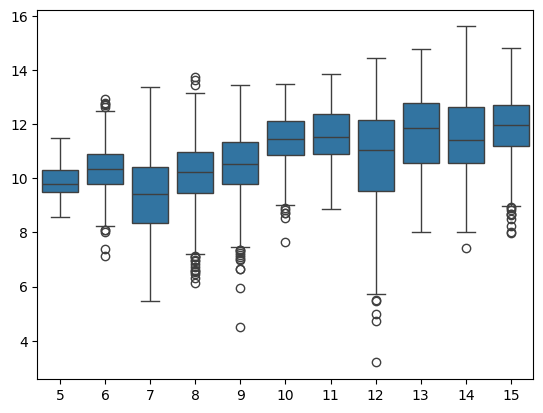

In [59]:
from matplotlib import pyplot as plt
import seaborn as sns

s=2

#disp = PredictionErrorDisplay.from_predictions(true_pred_pairs[s][0], true_pred_pairs[s][1], kind='actual_vs_predicted')


axes = sns.boxplot(x=true_pred_pairs[s][0], y=true_pred_pairs[s][1])
#axes.set_xticks(range(5,15))
#axes.set_yticks(range(4,18))



### Feature importance

In [45]:
from pprint import pprint

In [46]:
#Reverse the dictionary
index2features = {}
for i in range(len(SNIPPET_LENS)):
    index2feature = {}
    vectorizer = vectorizers[i]
    for feature,idx in vectorizer.vocabulary_.items():
        assert idx not in index2feature #This really should hold
        index2feature[idx]=feature
    index2features[i] = index2feature
#Now we can query index2feature to get the feature names as we need

In [47]:
highest_prios = {}
for i in range(6):
    model = models[i]
    # make a list of (weight, index), sort it
    lst=[]
    for idx,weight in enumerate(model.coef_):
        lst.append((weight,idx))
    lst.sort() #sort

    #Print first few and last few
    #for weight,idx in lst[:20]: #first 30 (ie lowest weight)
    #    print(index2feature[idx])
    #print("----------------------------------------------------")
    #Take the last 30 (lst[-30:]) but these now come from weakest to strongest
    #so reverse the list using [::-1]
    highest_prio = []
    for weight,idx in lst[-20:][::-1]:
        highest_prio.append(index2features[i][idx])
    highest_prios[i] = highest_prio

In [48]:
pprint(highest_prios)

{0: ['juuli',
     'tiny',
     'you',
     'sodan',
     '"',
     '.',
     'mulle',
     'veljeni',
     'noita',
     'istun',
     'mua',
     'hänen',
     'mun',
     'itseäni',
     'huulet',
     'i',
     'sormet',
     'olin',
     'kanssani',
     'oltiin'],
 1: ['juuli',
     'tiny',
     'you',
     '.',
     'hänen',
     '"',
     'mulle',
     'ollut',
     'noita',
     'i',
     'olin',
     'itseäni',
     'olen',
     'mun',
     'veljeni',
     'minulle',
     'mua',
     'kuin',
     '}',
     'istun'],
 2: ['juuli',
     'hänen',
     'you',
     '.',
     'tiny',
     'ollut',
     'olen',
     '"',
     'olin',
     'kuin',
     'en',
     'mun',
     'olisi',
     'minulle',
     'katsoo',
     'sodan',
     'mä',
     'minut',
     'i',
     'mua'],
 3: ['juuli',
     'hänen',
     'ollut',
     '.',
     'you',
     '"',
     'en',
     'olen',
     'olin',
     'mä',
     'tiny',
     'ei',
     'kuin',
     'mun',
     'olisi',
     'katsoo',
     'minull

### Clean up cache files

In [49]:
"""
for x in cache_file_trains:
    os.remove(x)
for x in cache_file_evals:
    os.remove(x)
for x in cache_file_tests:
    os.remove(x)
"""

'\nfor x in cache_file_trains:\n    os.remove(x)\nfor x in cache_file_evals:\n    os.remove(x)\nfor x in cache_file_tests:\n    os.remove(x)\n'